# Expense Analyzer

- Date : 01/02/2020
- Author : Aditya Warnulkar (adwarnulkar@gmail.com)

In [14]:
# expense from finance app
expenses_file = 'C:/Users/Aditya/workspace/finance_modeling/notebooks/expenses_december_2020.xls' # Expense report from Toshl finance

# budget allocation for this month
budget_file = 'C:/Users/Aditya/workspace/finance_modeling/notebooks/budget_december_2020.csv' # Budget file as per your standard of living

# 401k , HSA , ESPP contribution
company_deductions = 1419.66 + 1419.66

# Gross - TAX - company deductions
salary = (5601.7-1704.22) + (5606-1133.5) - company_deductions # Take home salary (After TAX/ESPP/HSA/401K)

In [15]:
salary

5530.66

In [16]:
company_deductions

2839.32

In [17]:
import sys
import os
import re

import pandas as pd
import numpy as np

import itertools

import matplotlib.pyplot as plt
%matplotlib inline

from bokeh.io import output_notebook , show
output_notebook()

SYS_PATH = 'C:\\Users\\Aditya\\workspace\\finance_modeling\\'
if SYS_PATH not in sys.path:
    sys.path.append(SYS_PATH)

from src import finance_post_process as fin

Loading BokehJS ...

In [18]:
df_expense = pd.read_excel(expenses_file,skiprows=1)
df_expense.head()

,Date,Account,Category,Tags,Amount,Currency,In main currency,Main currency,Description
0,12/1/20,Cash,Car,NaN,20.99,USD,20.99,USD,Car Wash
1,12/1/20,Cash,Gifts,NaN,28.79,USD,28.79,USD,USPS shopping
2,12/2/20,Cash,Grocery,NaN,14.07,USD,14.07,USD,Ralph’s
3,12/2/20,Cash,Bills,NaN,5.00,USD,5.00,USD,Maintenance Tip
4,12/3/20,Cash,Grocery,NaN,16.29,USD,16.29,USD,Walmart Groceries


In [19]:
df_budget = pd.read_csv(budget_file)
df_budget.set_index('Category',inplace=True)

In [20]:
df_expense = df_expense.groupby('Category').sum()['Amount']

In [21]:
df_expense = pd.concat([df_budget,df_expense],axis=1,sort=False)
df_expense.fillna(0,inplace=True)
df_expense['leverage'] = df_expense['budget'] - df_expense['Amount']
df_expense['leverage_perc'] = 100 * df_expense['leverage'] / df_expense['budget']
df_expense = df_expense.replace([np.inf, -np.inf], np.nan)
df_expense.fillna(0,inplace=True)
df_expense

,budget,Amount,leverage,leverage_perc
Home & Utilities,1565,1613.72,-48.72,-3.113099
Office Lunch,200,23.19,176.81,88.405000
Grocery,250,125.75,124.25,49.700000
Food & Drinks,230,242.05,-12.05,-5.239130
Bills,150,118.85,31.15,20.766667
Car,143,105.99,37.01,25.881119
Shopping,100,356.71,-256.71,-256.710000
Fuel,130,78.26,51.74,39.800000
Gifts,50,157.40,-107.40,-214.800000


In [22]:
print(f"Monthly Expenditure : ${df_expense.Amount.sum():.2f}")

Monthly Expenditure : $2821.92


In [23]:
print(f"Total Leverage : ${df_expense.leverage.sum():.2f}")

Total Leverage : $-3.92


## Plotting
- https://docs.bokeh.org/en/latest/docs/user_guide/categorical.html

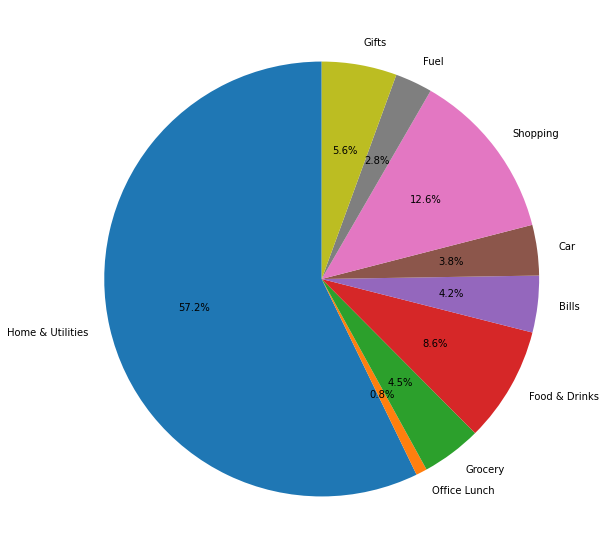

In [24]:
plt.figure(figsize=[10,10])
_ = plt.pie(df_expense.Amount,labels=df_expense.index,shadow=False, startangle=90,autopct='%1.1f%%')

In [25]:
show(fin.plot_expense(df_expense))

# Amount available for investment

In [26]:
salary_take_home = salary
salary_take_home

5530.66

In [27]:
print(f"Total Leverage : ${df_expense.leverage.sum():.2f}")

Total Leverage : $-3.92


In [28]:
storage = salary_take_home - df_expense.Amount.sum()
guilt_free_money = 0.1*storage
storage = storage - guilt_free_money
invest_perc = 100*storage/salary_take_home

print(f"Amount available for guilt free expenditure : ${guilt_free_money:.2f}")
print(f"Amount available for investment : ${storage:.2f} {invest_perc:.2f}%")

Amount available for guilt free expenditure : $270.87
Amount available for investment : $2437.87 44.08%


In [29]:
df_goal = pd.read_csv("model_goal_allocation.csv",index_col='goal',usecols=['goal','model_investment'])
df_goal['asset_ratio'] = df_goal.model_investment / df_goal.model_investment.sum()
df_goal['actual_investment'] = df_goal.asset_ratio * storage
df_goal['delta'] = df_goal.actual_investment - df_goal.model_investment
df_goal

,model_investment,asset_ratio,actual_investment,delta
goal,,,,
home,1550.693801,0.507803,1237.955261,-312.738540
vacation,234.204323,0.076694,186.970808,-47.233514
wedding,377.733955,0.123696,301.553883,-76.180072
retirement,891.100000,0.291807,711.386047,-179.713953


In [30]:
df_report = pd.concat([df_expense.Amount,df_goal.actual_investment])

In [31]:
df_report = df_report.append(pd.Series([guilt_free_money],index=['Guilt Free']))

In [32]:
df_report = df_report.to_frame(name='value')
df_report['percentage'] = 100*df_report.value/df_report.value.sum()
df_report["model_value"] = pd.concat([df_expense.budget , df_goal.model_investment])
df_report.fillna(0,inplace=True)
df_report

,value,percentage,model_value
Home & Utilities,1613.720000,29.177711,1565.000000
Office Lunch,23.190000,0.419299,200.000000
Grocery,125.750000,2.273689,250.000000
Food & Drinks,242.050000,4.376512,230.000000
Bills,118.850000,2.148930,150.000000
Car,105.990000,1.916408,143.000000
Shopping,356.710000,6.449682,100.000000
Fuel,78.260000,1.415021,130.000000
Gifts,157.400000,2.845953,50.000000
home,1237.955261,22.383500,1550.693801


In [33]:
df_report.sum()

value          5530.660000
percentage      100.000000
model_value    5871.732079
dtype: float64

In [34]:
df_report.to_csv('C:/Users/Aditya/workspace/finance_modeling/notebooks/report_december_2020.csv')